# Basic Info

## Team 1

- Ted Hsu ([thhsu4@illinois.edu](mailto:thhsu4@illinois.edu))
- Myles Iribarne ([mylesai2@illinois.edu](mailto:mylesai2@illinois.edu))
- Daniel Xu ([dhxu2@illinois.edu](mailto:dhxu2@illinois.edu))

## Paper

Our paper is _Transfer learning for ECG classification_ by Weimann and Conrad <cite data-cite="Weimann:2021wz">[1]</cite>. The project code is available on [Github](https://github.com/kweimann/ecg-transfer-learning/tree/master).

## TODO Video

Include a public link to your project video (Youtube/OneDrive/GDrive etc) at the top of the notebook.


# Abstract

This project replicates and extends a study on Atrial Fibrillation (AF) classification using ECG recordings <cite data-cite="Weimann:2021wz">[1]</cite>. The original study transferred pre-training learnings from distinct tasks in the _Icentia11k_ dataset to enhance performance of the fine-tuned model trained on the _PhysioNet/CinC Challenge 2017_ dataset to detect AF. Our results successfully replicated the original study's findings using beat classification for the pre-training step, notably demonstrating tha effects that the quantity of pre-training data has on final model performance. Pre-training on just 1% of the icentia11k dataset increased the F1 score of the fine-tuned model by 0.063. The remaining 99% of data increased the F1 score by a further 0.008.

We also explored an extension to the original method by integrating spectrogram feature preprocessing and a 2-D ResNet architecture, a shift from the original's 1-D convolutional approach. Our findings revealed that the 1-D model's pre-training advantages did extend to the 2-D model. The performance of the spectrogram-based models was equivalent to the 1-D model, and showed similar increase in performance when pre-training was applied.

# Introduction
## Background of the problem

- **What type of problem**:

  The problem is to classify Atrial Fibrillation (AF) on electrocardiogram (ECG) recordings.
- **What is the importance/meaning of solving the problem**:

  - A solution to the problem is a tool that will assist physicians in analyzing large amounts of patient ECG data in an automated and time efficient manner.
  - Early detection of AF events may lead to better patient outcomes.
  
- **What is the difficulty of the problem**:

  - Devices for recording patient ECG data are able to output a _huge_ amount of raw data. This is challenging and expensive to annotate for effective Deep Learning training.
  - Large class imbalance due to cardiovascular events of interests being rare.
  - Low ECG signal quality due to sampling frequency, single ECG lead probe.

- **The state of the art methods**:

  - Transfer learning using 1-D residual networks <cite data-cite="Kachuee:2018">[2]</cite>
  - Representation learning using encoder-decoder architectures
    - Stacked Denoising AEs <cite data-cite="Rahhal:2016">[3]</cite>
    - Seq2Seq model <cite data-cite="Rajan:2019">[4]</cite>

## Paper Explanation
- **What did the paper propose**:

  - Use Transfer learning to build better ECG classifiers.
  - Pre-train 1-D CNNs on the largest publicly available ECG dataset (_Icentia11k_) on several pre-training tasks:
    - Beat Classification
    - Rhythm Classification
    - Heart Rate Classification
    - Future Prediction
  - Fine-tune the pre-trained 1-D CNNs on a _different_ task and a _different_ dataset (_PhysioNet/CinC Challenge 2017_): classify AF events.

- **What is/are the innovations of the method**:

  - Demonstration of successful large-scale pre-training of 1-D CNNs on the largest publicly available ECG dataset to date.
  - Demonstration of contrastive pre-training (unsupervised representation learning) improving 1-D CNN performance on target task.
  - Novel usage of heart rate classification task for pre-training. Note that in this task, the labels can be automatically generated without manual intervention.

- **How well the proposed method work (in its own metrics)**:

  - The paper provides AF classifier performance comparison among five different pre-training tasks configurations (Random initialization, Beat classification, Rhythm classification, Heart Rate classification, and Future Prediction).
  
    **Macro F1 score of the AF classifier on the PhysioNet 2017 test set is the performance metric.**
  - The average macro F1 score of random initialization pre-training task is 0.731 over 10 trials. Average macro F1 scores reported by all proposed four pre-training tasks configurations range from 0.758 to 0.779 over 10 trials.

- **What is the contribution to the research regime (referring the Background above, how important the paper is to the problem)**:

  - Pre-training the 1-D CNN model improves the performance on the target task (i.e. AF classification), effectively reducing the number of labeled data required to achieve the same performance as 1-D CNNs that are not pre-trained.
  - Unsupervised pre-training (i.e. future prediction) on ECG data is a viable method for improving the performance on the target task and will become more relevant, since labeling ECG data is expensive.

# Scope of Reproducibility

## Hypothesis 1
Pre-training 1-D CNN models with an extremely large dataset of relatively inexpensively labeled data can improve performance of classification based on a smaller set of labeled data with a different classification objective (i.e. AF).

## Hypothesis 2
The paper does not explore how significant the effects of the pre-training data size are on the final results. We expect the size of the pre-training dataset affects the performance of the target task (i.e. AF classification).


## Verification
We will verify the hypotheses by attempting to reproduce results for a specific model and the following hyperparameter combination with 1%, 10%, 20%, and 100% of the pre-training data used in the paper:

- Model: 1-D ResNet-18v2
- Pre-training Objective: Beat Classification
- Frame Size: 4096 samples
- Sample Rate: 250 Hz
- Fine-tuning objective: Atrial Fibrillation

Note that the data is at patient level, so the percentages will be applied to the total number of patients.

The results will be compared with the performance of a randomly initialized ResNet-18v2.

## Implementation

The paper authors have provided their code online on Github. In our repo, we have forked their code and made small adjustments for convenience in our reproduction work. The code cells below will import modules from the paper authors' code. In this way, we are able to focus primarily on executing the experiments and analyzing the outcomes.


# Methodology

## Environment

First, we assume that this notebook is run in **Google Colab** with **Python 3.10**. It is highly recommended to have Colab Pro and select **V100** GPU or better. All results were generated using a V100 GPU with 16GB RAM, except for the ablation results. The ablation results were generated using L4 GPU with 22.5GB RAM.

Below we prepare the environment with which the code in this notebook can run.

First, we clone our project repo which is a fork of the original repo. Our repo also contains our modifications and our own original code.

In [88]:
REPO = "/tmp/repo"

In [89]:
%%capture
!git clone https://github.com/myles-i/DLH_TransferLearning.git {REPO}
%cd {REPO}

Second, we install all of the dependencies specified in `requirements.txt`. This [link](https://github.com/myles-i/DLH_TransferLearning/blob/master/requirements.txt) lists the dependencies used.

In [90]:
%%time
%%capture
!pip install -r requirements.txt

CPU times: user 54.3 ms, sys: 22.6 ms, total: 76.9 ms
Wall time: 6.06 s


Next, we prepare the directories for holding the data files we will use in later code cells of this notebook.

In [91]:
JOB_DIR = "/tmp/jobs"
DATA_DIR = "/tmp/data"
DEMO_DATA_DIR = DATA_DIR + "/final_demo"

In [92]:
%%capture
# Prepare local directories
!mdkir -p {JOB_DIR}
!mkdir -p {DATA_DIR}
!mkdir -p {DEMO_DATA_DIR}

##  Data

### Pre-training Dataset
The training data is the "Icentia11k Single Lead Continuous Raw Electrocardiogram Dataset," which is freely available online <cite data-cite="Icentiadata">[6]</cite><cite data-cite="Tan:2019icentia11k">[7]</cite><cite data-cite="PhysioNet:2000">[8]</cite>.



#### Data Download Instructions

Source of the data:

- The data comes in two formats, and links to each format are provided below:
  - [Raw](https://physionet.org/content/icentia11k-continuous-ecg/1.0/)
  - [Compressed](https://academictorrents.com/details/af04abfe9a3c96b30e5dd029eb185e19a7055272)

Download steps:

- We utilize the _compressed_ data files rather than the raw files.
- The process is demonstrated in this [notebook](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/Download_Icentia11k_Data.ipynb) which we wrote and used to download the data. It uses the `libtorrent` library to download the compressed data.
- The compressed data files are saved to an appropriately named sub-directory within the shared Google Drive directory stored in the `DATA_DIR` variable.


#### Description

Statistics:

- 11,000 patients.
- Using 4096 samples per patient, this is 4.5 million samples
- Each patient has up to two weeks of ECG recordings with 250 Hz sampling rate.
- Each ECG recording is accompanied with beat and rhythm labels marked by the ECG signal collection device and specialists, respectively.
- Both beat and rhythm labels are assigned to positions in the signal at irregular intervals.
- The original paper uses 95% of the patients for pre-training and the remaining 5% for validation.

#### Pre-processing Code and Command

First we look at patient#0's data as an example. The data processing code is from the paper authors' [original code](https://github.com/kweimann/ecg-transfer-learning/blob/master/transplant/datasets/icentia11k.py).


In [93]:
# First download Patient#0 ECG signal and labels
%%time
%%capture
# Patient#0 ECG signal
!gdown 1hzq0iSICypZTIrJcyPfAR5mPrKS1Vev_ \
  -O {DEMO_DATA_DIR + '/00000_batched.npy'}
# Patient#0 label
!gdown 1vjBhJ_0w-bTn7jhnRPS3Bf3CsLpi7RuN \
  -O {DEMO_DATA_DIR + '/00000_batched_lbls.npz'}

CPU times: user 117 ms, sys: 39.9 ms, total: 157 ms
Wall time: 15.6 s


In [94]:
from transplant.datasets import icentia11k

(signal, labels) = icentia11k.load_patient_data(
    DEMO_DATA_DIR, 0, include_labels=True, unzipped=True
)

Each patient's data is loaded as a tuple of ECG signal and labels.

In [95]:
print(f"ECG signal is 2D numpy array with shape {signal.shape}.")
print(
    f"With 250 Hz sampling rate, the length of ECG signal is:"
    f" {signal.shape[0]*signal.shape[1]/250/60:.2f} minutes."
)

ECG signal is 2D numpy array with shape (50, 1048577).
With 250 Hz sampling rate, the length of ECG signal is: 3495.26 minutes.


Each patient is labeled with beat type and rythm type:

In [96]:
print(f"{labels.keys()}")

dict_keys(['btype', 'rtype'])


The beat label in the Icentia11k dataset has 5 different values, as shown in the below code cell. The beat classification task is to classify beat type given a segment or a frame of an ECG signal. The paper experimented with frame sizes ranging from 2 to 60 seconds.

In [97]:
from pretraining import datasets

print(f"Beat labels: {datasets.icentia11k.ds_beat_names}")

Beat labels: {0: 'undefined', 1: 'normal', 2: 'pac', 3: 'aberrated', 4: 'pvc'}


The dict key `btype`'s value is a list of 50 elements, each element is a lst and corresponds to a row of ECG signal array mentioned above. The list's first element is the column number of the ECG signal array, and the second element is the associated label at the ECG signal.

In [98]:
print(
    f"patient #0's first beat label is:"
    f" {icentia11k.ds_beat_names[labels['btype'][0][1][0]]},"
)
print(
    f" at the first row and {labels['btype'][0][0][0]}th column"
    f" of the ECG signal array"
)

patient #0's first beat label is: normal,
 at the first row and 28th column of the ECG signal array


For beat classification pre-training, a frame of continuous ECG signal is extracted from a patient. The beat type associated with the frame is determined by the most occurrence of pac/aberrated/pvc. If none of the three types occur in the frame, the beat type is the most common between normal/undefined. The following is a snippet of the original code to extract an ECG signal frame and an associated label from a patient's data.

In [99]:
import numpy as np


frame_size = 4096
num_segments, segment_size = signal.shape
patient_beat_labels = labels["btype"]

# original code: np.random.randint(num_segments)
segment_index = 17
# original code: np.random.randint(segment_size - frame_size)
frame_start = 45678
frame_end = frame_start + frame_size

x = signal[segment_index, frame_start:frame_end]
x = np.expand_dims(x, axis=1)  # add channel dimension

# calculate the count of each beat type in the frame and determine the final
# label
beat_ends, beat_labels = patient_beat_labels[segment_index]
_, frame_beat_labels = icentia11k.get_complete_beats(
    beat_ends, beat_labels, frame_start, frame_end
)
y = icentia11k.get_beat_label(frame_beat_labels)

print("Data sample from patient #0:")
print(
    f"ECG signal segment={segment_index}, frame_start={frame_start},"
    f" frame_end={frame_end}"
)
print(f"Number of beat labels in the frame: {len(frame_beat_labels)}")
print(f"- Undefined: {np.sum(frame_beat_labels == 0)}")
print(f"- Normal: {np.sum(frame_beat_labels == 1)}")
print(
    f"Final beat label of the data sample: {icentia11k.ds_beat_names[y]}"
)

Data sample from patient #0:
ECG signal segment=17, frame_start=45678, frame_end=49774
Number of beat labels in the frame: 26
- Undefined: 6
- Normal: 20
Final beat label of the data sample: normal


#### Exploration and visualizations


The original code includes a `beat_generator` as data generator for beat classification task. Below is example code to generate a training data sample from Patient#0 with an ECG signal frame size of 4096:

In [100]:
from pretraining import datasets

gen = datasets.beat_generator(
    DEMO_DATA_DIR,
    patient_ids=[0],  # Patient#0
    frame_size=4096,  # a frame with 4096 continuous ECG signal
    normalize=True,
    unzipped=True,
    samples_per_patient=1,
)
data = next(gen)

Each data sample is a tuple of ECG signal and beat label. With a frame size of 4096 and 250 Hz sampling rate, the length of this sample is around 16 seconds.

Beat label of the data sample: normal


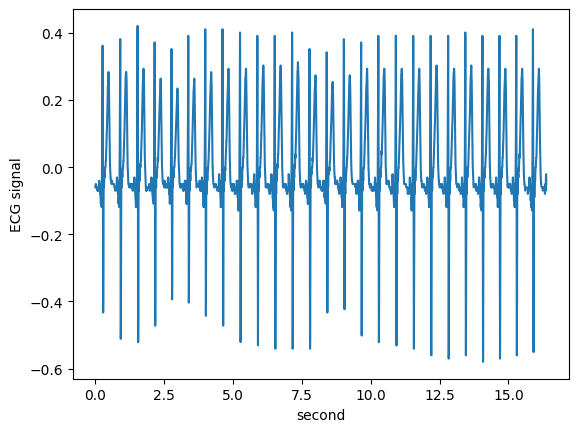

In [101]:
from matplotlib import pyplot as plt
import numpy as np

print(
    f"Beat label of the data sample:"
    f" {datasets.icentia11k.ds_beat_names[data[1]]}"
)
_ = plt.plot(np.arange(len(data[0])) / 250, data[0])
_ = plt.xlabel("second")
_ = plt.ylabel("ECG signal")

The `beat_generator` is used to create a `tensorflow` `Dataset` object. The following code creates a `Dataset` that contains 2048 training data samples from Patient#0, each training data sample with frame size 2048.

**Dataset generator code:**

In [102]:
dataset = datasets.beat_dataset(
    db_dir=DEMO_DATA_DIR,
    patient_ids=[0],
    frame_size=2048,
    unzipped=True,
    samples_per_patient=2048,
)
dataset.element_spec

(TensorSpec(shape=(2048, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

### Fine-tuning Dataset
The fine-tuning dataset is the "AF Classification from a Short Single Lead ECG Recording: The PhysioNet/Computing in Cardiology Challenge 2017" and freely available online for download <cite data-cite="PhysioNet:2000">[8]</cite><cite data-cite="Clifford:2017we">[9]</cite>.



#### Data Download Instructions

Source of the data

  - [Raw](https://physionet.org/content/challenge-2017/1.0.0/).

Download instructions:

- Simply do a direct download of the data from the PhysioNet website.
- The `train2017.zip` file needs to be saved somewhere for subsequent pre-processing.

#### Description

Statistics

- 8528 short ECG recordings.
- Each ECG recording duration is 9 to 60 seconds with 300 Hz sampling rate.
- Each ECG recording is labeled with one of the following classes: AF, Normal, Other or Noise (too noisy to classify).

#### Pre-processing Code and Command

A brief summary of the steps in pre-processing of the fine-tuning dataset:

- Resampling to 250 Hz to match the sample rate of the pre-training dataset.
- Padding records to 65 seconds.
- Standardizing the data using mean and standard deviation computed on the entire dataset.

The `get_challenge17_data` function ([source](https://github.com/myles-i/DLH_TransferLearning/blob/master/finetuning/datasets.py#L9)) in the authors' code both extracts and pre-processes the _PhysioNet 2017_ dataset. We split the data extraction and pre-processing steps and saved the extracted data. This lets us have the flexibility of pre-processing without data extraction in every run. The below cell demonstrates an example of data pre-processing.

In [103]:
%%time
%%capture
# Downloads the raw PhysioNet record and label pickles, the output of
# extraction.
!gdown 1lI7lTZltRj_zQtYM1UcidZnSAQilPJSg -O {DEMO_DATA_DIR} --folder

CPU times: user 81 ms, sys: 37 ms, total: 118 ms
Wall time: 8.69 s


Note that downloading the extracted data took less than 10 seconds. We experienced 45 minutes for the data extraction, thus splitting the original `get_challenge17_data` function made our fine-tuning data preparation much more efficient.

In [104]:
import functools

import numpy as np

from finetuning import datasets
from transplant.datasets import physionet


def extract_challenge17_data(db_dir, verbose=False):
    # This is the author's extraction code
    records, labels = physionet.read_challenge17_data(db_dir, verbose=verbose)
    return records, labels


def process_extracted_challenge17_data(
    records, labels, fs=None, pad=None, normalize=False, verbose=False
):
    """
    This is our code that performs pre-processing only.

    Args:
        records: See extract_challenge17_data.
        labels: See extract_challenge17_data.
        fs (int): Sampling rate.
        pad (int): Length that each record should be padded to (or truncated)
            pad / fs will give the approximate length in seconds.
        normalize (bool): Whether to standardize the records using mean and s.d.
            computed over the entire dataset. Note that the mean and s.d. have
            already been provided by the authors.
    """
    if normalize:
        normalize = functools.partial(
            physionet.normalize_challenge17, inplace=True
        )
    # This is the author's preprocessing code
    data_set = datasets._prepare_data(
        records,
        labels,
        normalize_fn=normalize,
        fs=fs,
        pad=pad,
        verbose=verbose,
    )
    return data_set

In [105]:
%%time
from transplant.utils import load_pkl

records = load_pkl(f"{DEMO_DATA_DIR}/records.pkl")["data"]
labels = load_pkl(f"{DEMO_DATA_DIR}/labels.pkl")["data"]
physionet_data = process_extracted_challenge17_data(
    records,
    labels,
    fs=250,
    pad=16384,
    normalize=True,
    verbose=True,
)

Resampling records: 100%|██████████| 8528/8528 [00:04<00:00, 2076.37it/s]


CPU times: user 7.34 s, sys: 1.1 s, total: 8.44 s
Wall time: 8.39 s


#### Exploration and Visualization

Please note that the exploration is done on the data after pre-processing.

Labels are in the form one-hot encoded arrays. The labels `A`, `N`, `O` and `~` represent AF, Normal, Other and Noise, respectively.

The distribution of label values is shown below. Note that less than 10% of the data is labeled AF.

In [106]:
print(f"Shape of the fine-tuning data labels: {labels.shape}")
labels.value_counts()

Shape of the fine-tuning data labels: (8528, 4)


A  N  O  ~
0  1  0  0    5050
   0  1  0    2456
1  0  0  0     738
0  0  0  1     284
Name: count, dtype: int64

The `_prepare_data()` function packs ECG signals (resampled and padded) and labels into a dictionary ready to be consumed by `train_test_split` in `sklearn`. To save data pre-processing time in the fine-tuning procedure, we split the pre-processed data (i.e. the `physionet_data` variable) into train and test sets and saved them in pickle form.

In [107]:
print("PhysioNet data summary:")
print(f'Number of samples: {len(physionet_data["x"])}')
print(f"labels: {physionet_data['classes']}")
print(f'Dimensions of a sample: {physionet_data["x"][0].shape}')

PhysioNet data summary:
Number of samples: 8528
labels: ['A' 'N' 'O' '~']
Dimensions of a sample: (16384, 1)


Record id: A00004
One-hot encoded label: [1 0 0 0]


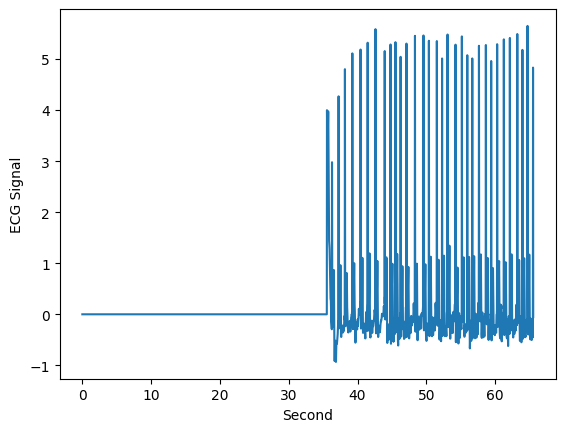

In [108]:
print(f'Record id: {physionet_data["record_ids"][3]}')
print(f'One-hot encoded label: {physionet_data["y"][3]}')
_ = plt.plot(
    np.arange(physionet_data["x"][3].shape[0]) / 250, physionet_data["x"][3]
)
_ = plt.xlabel("Second")
_ = plt.ylabel("ECG Signal")

## Model
In this project, the CNN model of choice is ResNet-18v2. This was used in the original paper <cite data-cite="Weimann:2021wz">[1]</cite>.

[Link](https://github.com/kweimann/ecg-transfer-learning/blob/master/transplant/modules/resnet1d.py) to the original paper's model definition. This implementation code is also in our repo [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/modules/resnet1d.py).

The ResNet architecture is based on the original design by He et al <cite data-cite="he2016identity">[10]</cite>.

We show how to use the paper authors' code to create a 1-D ResNet-18v2 for beat classification in pre-training and AF classification in fine-tuning.

* Model architecture
  * 18 layers
  * Input layer consists of convolution layer with 64 filters, kernel size=3 and stride=2. The output of the convolution layer passes through batch norm, ReLu and max-pooling layers sequentially.
  * Output layer is a classifier consisting of a densely-connected layer followed by softmax function.
  * The middle 16 layers consist of 8 residual blocks. A residual block consists of the following two components and outputs the sum of the two components' outputs.
    1. Two convolution layers, each followed by batch norm and ReLu.
    2. A shortcut that passes the input through a convolution layer followed by batch norm.
  * Configurations of the residual blocks
    * 1st and 2nd: 64 filters, kernel size=7, strides=2 and 1, respectively
    * 3rd and 4th: 128 filters, kernel size=5, strides=2 and 1, respectively
    * 5th and 6th: 256 filters, kernel size=5, strides=2 and 1, respectively
    * 7th and 8th: 512 filters, kernel size=3, strides=2 and 1, respectively
  * Detail of [implementation code here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/modules/resnet1d.py).
* Pre-training objectives
  * Loss function: [Sparse Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
    * `from_logits=True`
    * All other parameters are set to their default values.
  * Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * `beta_1`: 0.9
    * `beta_2`: 0.98
    * All other parameters are set to their default values.
  * Metric: [Sparse Categorical Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy)
* Fine-tuning objectives
  * Loss function: [Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
    * All parameters are set to their default values.
  * Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * All other parameters are set to their default values.
  * Metrics:
    * [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy)
    * Macro F1. See our `my_f1()` function below.


Pre-trained model weights with patients 0-2047 of the _Icentia11k_ dataset (~20%) can be downloaded from Google Drive [here](https://drive.google.com/file/d/1-9hQzriOv6y6DUu_ND23lwqGo6zv78yv/view?usp=sharing).

Pre-trained model weights we trained with all patients of the _Icentia11k_ dataset (100%) can be downloaded from Google Drive [here](https://drive.google.com/file/d/1-I6J8AEJaWiNI88LGQ5tjLOVMd-qbxdu/view?usp=sharing).


### Pre-training Model Initialization and Summary
Below we construct the pre-training ResNet-18v2 and show its structure.


In [109]:
import tensorflow as tf

from transplant.modules.resnet1d import ResNet
from transplant.datasets import icentia11k
from transplant.modules.utils import build_input_tensor_from_shape


resnet = ResNet(
    num_outputs=None,
    blocks=(2, 2, 2, 2),
    kernel_size=(7, 5, 5, 3),
    include_top=False,
)

feature_extractor = tf.keras.Sequential(
    [resnet, tf.keras.layers.GlobalAveragePooling1D()]
)

num_classes = len(icentia11k.ds_beat_names)  # 5

model = tf.keras.Sequential(
    [feature_extractor, tf.keras.layers.Dense(num_classes)]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

# Initialize the weights of the model
train_data = dataset.batch(32)
input_shape, _ = tf.compat.v1.data.get_output_shapes(train_data)
input_dtype, _ = tf.compat.v1.data.get_output_types(train_data)
inputs = build_input_tensor_from_shape(
    input_shape, dtype=input_dtype, ignore_batch_dim=True
)
model(inputs)
model.summary(expand_nested=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 512)               4492480   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| res_net_2 (ResNet)         (None, 64, 512)           4492480  |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| conv1d_2 (Conv1D)         multiple                  448     ||
||                                                             ||
|| batch_normalization_22 (  multiple                  256     ||
|| BatchNormalization)                                         ||
||                                                             ||
|| re_lu_2 (ReLU)            multiple                  0       ||
||                                                             ||
|| max_pooling1d_2 (MaxPool  multiple                  0       ||
|| ing1D)                                             

### Fine-tuning Model Initialization and Summary

The fine-tuning model in the paper is the pre-training model with its output layer replaced with a fully connected layer that matches the classes of the _PhysioNet 2017_ dataset and has randomly initialized weights. Below is a demonstration to construct fine-tuning CNN model. Note the model's number of parameters is identical to that of the pre-training CNN, and the output layer has four outputs, instead of five.

In [110]:
resnet2 = ResNet(
    num_outputs=None,
    blocks=(2, 2, 2, 2),
    kernel_size=(7, 5, 5, 3),
    include_top=False,
)

ft_model = tf.keras.Sequential(
    [resnet2, tf.keras.layers.GlobalAveragePooling1D()]
)

# Initialize the weights of the model
inputs = tf.keras.layers.Input(
    physionet_data["x"].shape[1:], dtype=physionet_data["x"].dtype
)
ft_model(inputs)

# Load pre-training weights, if any
pre_trained_weights = None
if pre_trained_weights:
    ft_model.load_weights(pre_trained_weights)

# Replace output layer
num_classes = len(physionet_data["classes"])  # 4
ft_model.add(
    tf.keras.layers.Dense(num_classes, activation="softmax", name="new_dense")
)

ft_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
)
ft_model.summary(expand_nested=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_3 (ResNet)          (None, 512, 512)          4492480   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d_3 (Conv1D)          multiple                  448      |
|                                                               |
| batch_normalization_23 (B  multiple                  256      |
| atchNormalization)                                            |
|                                                               |
| re_lu_3 (ReLU)             multiple                  0        |
|                                                               |
| max_pooling1d_3 (MaxPooli  multiple                  0        |
| ng1D)                                                         |
|                                                               |
| residual_block_24 (Residu  multiple                 

## Training

### Hyperparameters

#### Pre-training

* Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * `beta_1`: 0.9
    * `beta_2`: 0.98
    * All other parameters are set to their default values.
* Sample frequency: 250 Hz
* Frame Size: 4096 (about 16 seconds at 250 Hz)
* Batch Size: 512
* `samples_per_patient`: 4096
* Hidden size: Please refer to the "Models" section for details.

#### Fine-tuning

* Optimizer: [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
    * `learning_rate`: 0.001 (default)
    * All other parameters are set to their default values.
* Batch size: 128
    * This size was chosen to maximize the GPU RAM usage of the V100 GPU on Google Colab.
* Sample rate: 250 Hz (resampled from 300 Hz)
* Frame size: 16384
    * Approximately 65 seconds
    * Shorter samples are left-padded with zeroes
* Hidden size: Please refer to the "Models" section for details.

### Computational Requirements


#### Pre-training

* Type of Hardware: V100 GPU
    - Batch size of 512 used to fully utilize the 16 GB of RAM on the V100 GPU.
    - However, our training rate has been limited by not by the GPU speed, but the I/O time required to transfer, load, and unzip the data files from google drive distributed file system. For example, training on 32x more data per patient only increased runtime by 2.2x, since most of the time was spent loading the same amount of patient data files.
    - We experimented with using A100 GPUs which has more RAM (i.e. larger batch size) and is generally faster. But we were unable to get significant speed improvements to justify the extra hourly cost of the A100 GPU due to distributed I/O latency associated with Google Drive.
* Average runtime per 1,000 patients: 1 hours, 16 minutes
* Total number of trials: 1
* GPU hours used: 14 hours
    - Frame size 4096
    - 11000 patients x 4096 samples per data = **45 million samples**

**Note on epochs**: Both the author and our analysis only ever uses a patient's data once during pre-training, thus the 1 epoch. However, the code's definition of an "epoch" during pre-training has a different meaning and refers to the processing one set of data equal to `batch_size x steps_per_epoch`. This can have variable amounts of data or patients.

Also note that during pre-training, we saved 100 checkpoints to be able to study how fine-tuning on different amounts of pre-training affects the final model's performance after fine-tuning.

#### Fine-tuning

* Type of Hardware: V100 GPU
    - Batch size of 128 used to fully utilize the 16 GB of RAM on the V100 GPU.
    - Unlike in pre-training, we did not experience I/O overhead during training as the processed _PhysioNet 2017_ train and test data (pickles) were able to fit into RAM.
* Average runtime for each epoch: Between 21 to 22 seconds.
* Total number of trials: 50
    - 10 trials for each of the five scenarios: Random, 1%, 10%, 20%, and 100%.
* GPU hours used: About 21.2 hours total.
    - Random: 5.3 hours
    - 1%: 3.9 hours
    - 10%: 4.1 hours
    - 20%: 4.3 hours
    - 100%: 3.6 hours
* Number of training epochs: Maximum 200 per trial, but in practice, saw early stopping by 80 epochs.
    - Training for a single trial would typically complete within 30 minutes.

### Training Code Snippet Sample


#### Pre-training
For beat classification pre-training, a checkpoint function is created to monitor training loss and save model weights of each epoch. The below cell demonstrates pre-training with a small dataset.

* Note that the model weights of each epoch are saved for fine-tuning model initialization.
* Also note that in `keras` and the way the authors implemented the pre-training step, 1 epoch is defined by batch size and steps-per-epoch (it does not imply training on the entire dataset once).

In [111]:
FINAL_DEMO_JOB = JOB_DIR + "/final_demo"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(FINAL_DEMO_JOB + "/epoch_{epoch:02d}" + "/model.weights"),
    monitor="loss",
    save_best_only=False,
    save_weights_only=True,
    mode="auto",
    verbose=1,
)

_ = model.fit(
    train_data,
    steps_per_epoch=64,
    verbose=2,
    epochs=2,
    validation_data=None,
    callbacks=[checkpoint],
)

Epoch 1/2

Epoch 1: saving model to /tmp/jobs/final_demo/epoch_01/model.weights
64/64 - 14s - loss: 0.1802 - acc: 0.9517 - 14s/epoch - 223ms/step
Epoch 2/2

Epoch 2: saving model to /tmp/jobs/final_demo/epoch_02/model.weights
64/64 - 4s - loss: 0.1013 - acc: 0.9712 - 4s/epoch - 57ms/step


#### Fine-tuning

The procedure to fine-tune the 1-D ResNet-18v2 model is identical to the pre-training procedure, except that a custom checkpoint function is used to calculate macro F1 score on the validation dataset at the end of a training epoch and save the model weights if a better macro F1 score is reported. The following is an example of the `CustomCheckpoint` from the original code.

In [112]:
from transplant.evaluation import f1, CustomCheckpoint

val_data = physionet_data["x"][3]
val_y = physionet_data["y"][3]

checkpoint = CustomCheckpoint(
    filepath=str(FINAL_DEMO_JOB + "/fine-tuning/best_model.weights"),
    data=(val_data, val_y),
    score_fn=f1,
    save_best_only=True,
    verbose=1,
)

### Training Code - Command Line API

The paper authors provide entrypoint scripts to run the entire pre-training and fine-tuning process with parameters of choice. The following is the high level description of how the scripts work.

#### Pre-training

The source code from the paper authors can be found [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/pretraining).

1. Create train/validate data generator based on patient ID and the number of samples per patient, both specified when calling the entrypoint.
2. A model is generated based on the model architecture and pre-training task specified by the user.
3. Weights of the model are initialized. They can also be loaded from a weights file. For all pre-training in the project, we don't load weights.
4. Checkpoint function is created based on training metric. For pre-training, we use `loss` as training metric.
5. The model fits the train data. At the end of each training epoch, the checkpoint function is called for evaluation and save the model weights.

The paper uses 95% of the patient's ECG data. On average, the paper sampled 4096 ECG frames per patient, which amounts to 42.8 million (11000x0.95x4096) training samples over the course of pre-training. For pre-training with 20% of the data used in paper, we use ECG data from 2048 patients and sample 4096 ECG frames per patient, resulting to roughly 8.4 million (2048x4096) training samples.

The following sample command calls the pre-training entrypoint to run pre-training with 20% of the data used in the paper (Patients 0 through 2047).

* The command is easily adapted to run pre-training with 10% of the data in the paper.

```bash
!time python -m pretraining.trainer \
--job-dir "jobs/beat_classification_16epochs_to_20percent" \
--task "beat" \
--train {TRAIN_DATASET} \
--arch "resnet18" \
--epochs 16 \
--patient-ids `seq 0 2047 | paste -sd, -` \
--steps-per-epoch 1024 \
--samples-per-patient 4096 \
--batch-size 512 \
--frame-size 4096
```

Explanation of the less obvious parameters:

* `--job-dir`: Output directory, where check points and weights are saved.

* `--task`: Pre-training task, `beat` for Beat classification.

* `--patient-ids`: Patient id(s) whose ECG data to be used in pre-training.

  * Multiple patients can be specified by passing a space separated sequence of ids.

* `--frame-size`: Number of ECG samples, with 250 Hz sampling rate, in a ECG frame.

To use all data: number of patients x samples_per_patient = epochs x batch_size x steps-per-epoch.

For demonstration, we run the script in a much smaller scale below:

In [113]:
PRETRAIN_JOB_DIR = FINAL_DEMO_JOB + "/pretraining"

In [114]:
%%time
!python -m pretraining.trainer \
--job-dir {PRETRAIN_JOB_DIR} \
--task "beat" \
--train {DEMO_DATA_DIR} \
--arch "resnet18" \
--epochs 2 \
--patient-ids 0 \
--steps-per-epoch 8 \
--samples-per-patient 4096 \
--batch-size 256 \
--frame-size 1024 \
--unzipped True \
--seed 2024

2024-05-06 15:26:06.304834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:26:06.304900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:26:06.306216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 15:26:07.344647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/jobs/final_demo/pretraining
Setting random state 2024
Building train data generators
# Patient IDs:  1
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature

#### Fine-tuning

The source code from the paper authors can be found [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/finetuning).

1. Train and test data set are already separated from the _PhysioNet 2017_ dataset, with a 80%-20% split, and are passed to the entrypoint. The validation dataset will be further separated from the train dataset based on user input.
2. A CNN model is generated based on the model architecture specified by the user. Its output layer is fully connected with softmax activation.
3. The weights of the model are initialized. They can also be loaded from a weights file. If using a weights model from pre-training, this first has to be pre-processed using the "pretraining.utils.get_pretrained_weights" function to remove the classification layer, which is replaced during finetuning. An example of this process can be see [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/jupyter_notebooks/finetune_pretrain_20_weights_65sec.ipynb)
4. Checkpoint function is created based on validation metric. For fine-tuning, we use `f1` (macro F1) as the metric.
5. The model fits the train data. At the end of each training epoch, the checkpoint function is called for evaluation and saves the model weights with best macro F1 score on the validation set. Note that the model also is setup to end training early if the validation loss does not decrease after 50 epochs.
6. The model is evaluated on the test set and the predicted probabilities are saved to a csv file.

Ultimately, the two most important outputs of a fine-tuning execution are:

- History file containing validation macro F1 score at the end of each epoch.
- Model predictions on the test set.

The following sample command calls the fine-tuning entrypoint to run fine-tuning with _random initialization_.

```bash
python -m finetuning.trainer \
--job-dir {JOB_DIR} \
--train {FINETUNE_TRAIN} \
--test {FINETUNE_TEST} \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 200 \
--seed 2024 \
--verbose
```

Explanation of the less obvious parameters:

* `--job-dir`: Output directory, where checkpoints and weights are saved.
* `--val-size`: This is the percentage of the train set size to set aside for the validation set.
  * Note that the _PhysioNet 2017_ data was already split into 80% train, 20% test. The paper uses 5% of the full dataset for validation.
  * Math: $6.25\% * 80\% = 5\%$.
* `--val-metric`: Metric to evaluate the model at the end of each epoch on the validation dataset.
* `--seed`: Random state used to split the train into smaller train and validation.

Below is a small scale demonstration of fine-tuning with random weight initialization. We first download the fine-tuning train and test datasets.

In [115]:
FINETUNE_TRAIN = DEMO_DATA_DIR + "/physionet_train.pkl"
FINETUNE_TEST = DEMO_DATA_DIR + "/physionet_test.pkl"

In [116]:
%%capture
!gdown 10PVz1nmMaeIgxQ4sqDUeZlzhFVHOth5I -O {FINETUNE_TRAIN}
!gdown 10FKjncGOZD6_BBCBbvpBQbWvfCLj88MC -O {FINETUNE_TEST}

In [117]:
FINETUNE_JOB_DIR = FINAL_DEMO_JOB + "/finetuning_random"

Then, we run the fine-tuning entrypoint and run fine-tuning for two epochs.

In [118]:
%%time
!python -m finetuning.trainer \
--job-dir {FINETUNE_JOB_DIR} \
--train {FINETUNE_TRAIN} \
--test {FINETUNE_TEST} \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 2 \
--seed 2024 \
--verbose

2024-05-06 15:26:43.573061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:26:43.573113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:26:43.574359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 15:26:44.629321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/jobs/final_demo/finetuning_random
Setting random state 2024
Loading train data from /tmp/data/final_demo/physionet_train.pkl ...
Split data into train 93.73% and validation 6.27%
Loading test data from /tmp

The following sample command uses the fine-tuning entrypoint to run fine-tuning with pre-trained weights.

```bash
python -m finetuning.trainer \
--job-dir {JOB_DIR} \
--train {FINETUNE_TRAIN} \
--test {FINETUNE_TEST} \
--weights-file {WEIGHTS_FILE} \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 200 \
--seed 2024 \
--verbose
```

This is largely the same command as the previous example for fine-tuning a randomly initialized network. But with this addition:

* `--weights-file {WEIGHTS_FILE}`: Path to pre-trained weights or a checkpoint of the model to be used for model initialization.

Below is a small demonstration using weights obtained from pre-training using 20% of the _Icentia11k_ dataset. We first download model weights from our experiments.

In [119]:
%%time
%%capture
!mkdir -p {JOB_DIR + '/finetune_pretrain_20_weights_65sec'}
!gdown 1-A0AqZe9sanj-8MZnoX4TUAYWrgcUTlg \
    -O {JOB_DIR + '/finetune_pretrain_20_weights_65sec'} --folder

CPU times: user 127 ms, sys: 42.2 ms, total: 170 ms
Wall time: 20.3 s


In [120]:
WEIGHTS_FILE = (
    JOB_DIR + "/finetune_pretrain_20_weights_65sec/best_model.weights"
)
FINETUNE_JOB_DIR = FINAL_DEMO_JOB + "/finetuning_pretrained"

In [121]:
%%time
!python -m finetuning.trainer \
--job-dir {FINETUNE_JOB_DIR} \
--train {FINETUNE_TRAIN} \
--test {FINETUNE_TEST} \
--weights-file {WEIGHTS_FILE} \
--val-size 0.0625 \
--val-metric "f1" \
--arch "resnet18" \
--batch-size 128 \
--epochs 2 \
--seed 2024 \
--verbose

2024-05-06 15:28:58.276124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:28:58.276173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:28:58.277414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 15:28:59.295234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/jobs/final_demo/finetuning_pretrained
Setting random state 2024
Loading train data from /tmp/data/final_demo/physionet_train.pkl ...
Split data into train 93.73% and validation 6.27%
Loading test data from 

## Evaluation

### Pre-training

The original paper doesn't discuss the performance of the 1-D ResNet-18v2 on pre-training task and focuses the analysis on the comparison between the fine-tuned model with random initialized weights and fine-tuned models with pre-trained weights. In addition, our Hypotheses 1 and 2 are about the impact on the fine-tuning task performance. Therefore, we don't evaluate pre-training task performance in this report.

### Fine-tuning

#### Metrics Descriptions

In fine-tuning, the paper uses macro F1 score for evaluating the model on the _PhysioNet 2017_ validation and test sets.


#### Evaluation Code

We define our macro F1 function `my_f1`, shown below and is also on Github [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/report/common.py#L6-L9). It is named like that because the paper authors define their F1 function named `f1` and we wish to avoid namespace collision. Additionally, our macro F1 function supports providing per-class F1 scores, which the _original_ `f1` function does not support.

See also the Analysis section for how we are using this metric in our results.

In [122]:
from sklearn.metrics import f1_score
import numpy as np


def my_f1(y_true, y_prob, average="macro"):
    # set average=None to get per-class F1 scores.
    y_pred = y_prob >= np.max(y_prob, axis=1)[:, None]
    return f1_score(y_true, y_pred, average=average)

# Results

As specified, we used the fine-tuning entrypoint script to fine-tune a 1-D ResNet-18v2 model with the following five scenarios relating to the weights used to initialize the model before commencing fine-tuning:

* Random initialization.
* Pre-training weights from training with 1% of the data.
* Pre-training weights from training with 10% of the data.
* Pre-training weights from training with 20% of the data.
* Pre-training weights from training with 100% of the data.

Then we evaluate each model using macro F1 score on the following two datasets:

* Validation set during fine-tuning training.
* Test set.

Finally, we compare the results of all five models.

For each scenario, we ran fine-tuning 10 times with 10 different seeds. We did this in order to obtain average macro F1 scores, just as was done by the paper authors. Recall that the seed controls the split of the input data into a train set and validation set.

The same 10 seeds are used to fine-tune all five scenarios to enable apples-to-apples comparison of the macro F1 scores among the three models. Specifically, we used seeds 10, 20, ..., 100.

To facilitate analysis of the results, we have separately collated the output files from each trial (scenario and seed combination) into two files:

- All history csv file
- All test predictions pickle

More details may be found in this [notebook](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/collate_1d_finetune_results.ipynb).

In the below cell, we download the collated fine-tuning result files.

In [123]:
RESULT1D_DIR = "/tmp/results1d"

In [124]:
%%time
%%capture
!mkdir -p {RESULT1D_DIR}
!gdown 1emWqhhDG4fp-Io8dPPa6CiKGS0EgQUVJ -O {RESULT1D_DIR} --folder

CPU times: user 149 ms, sys: 26.4 ms, total: 176 ms
Wall time: 21.8 s


## Figures and Tables

In this section, we generate the tables and figures to then be referenced in the Analysis section below, as well as in the Discussion. To keep this report short, the analysis code is located in a separate file and imported into this notebook. The code may be inspected on Github [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/report/analysis1d.py).

Below we import the code as the `analysis1d` module.

In [125]:
from report import analysis1d

### Table 1: Epoch Comparison

We create a table of the average and standard deviation of the number of epochs before training is stopped early due to validation loss not decreasing for 50 epochs for each scenario. The `make_epoch_table` code can be found on Github [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/report/analysis1d.py#L7).

In [126]:
import pandas as pd

history_all = pd.read_csv(RESULT1D_DIR + "/history_all.csv")
analysis1d.make_epoch_table(history_all)

,Scenario,Mean,Std
0,Random,71.0,5.6
1,Pre-train 1,62.5,5.2
2,Pre-train 10,56.2,2.1
3,Pre-train 20,56.8,2.6
4,Pre-train 100,57.0,2.1


### Figure 1: Average Validation Macro F1 Comparison

We plot the average validation macro F1 scores by epoch for each of the five scenarios using `plot_f1_by_epoch()` ([source](https://github.com/myles-i/DLH_TransferLearning/blob/master/report/analysis1d.py#L39)).

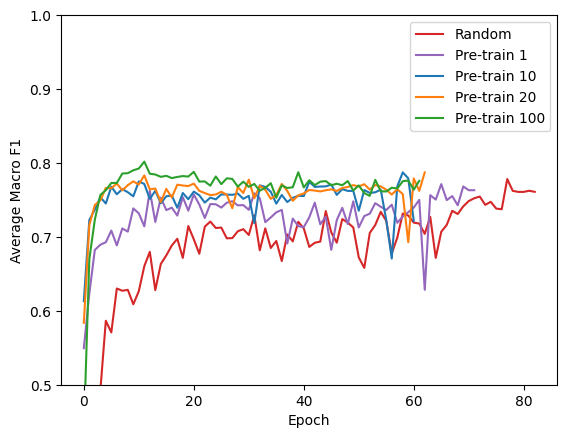

In [127]:
analysis1d.plot_f1_by_epoch(history_all)

### Figure 2: Average Validation Macro F1 between Random and Pre-trained Scenario

Similar to Figure 1, but with only random and pre-trained 100% scenarios and we also include shaded regions for each line. The shaded region represents the area between the maximum and minimum macro F1 score for that epoch among the 10 trials for a scenario. The `plot_f1_by_epoch_with_range` function is used to generate Figure 2 ([source](https://github.com/myles-i/DLH_TransferLearning/blob/master/report/analysis1d.py#L84)).

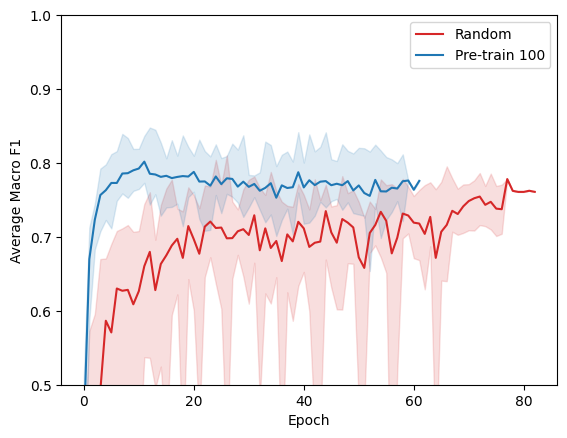

In [128]:
analysis1d.plot_f1_by_epoch_with_range(history_all)

### Table 2: Average Test Macro F1 Comparison

Recall that the fine-tuning entrypoint performs inference on the test set using the model with the highest validation macro F1 score.

We use `make_f1_table()` ([source](https://github.com/myles-i/DLH_TransferLearning/blob/master/report/analysis1d.py#L127)) to generate a table that is similar in format to Table 1 of the paper.

For each scenario, we report the average macro F1 score (and the standard deviation) on the test set. We also report the average F1 score for each class in the _PhysioNet 2017_ dataset:

- Normal (F1n)
- AF (F1a)
- Other (F1o)
- Noisy (F1p)

In [129]:
from transplant.utils import load_pkl

predictions_all = load_pkl(RESULT1D_DIR + "/predictions_all.pkl")
analysis1d.make_f1_table(predictions_all)

,Type,F1,F1n,F1a,F1o,F1p
0,Random,.702 (± .030),.881 (± .011),.647 (± .048),.686 (± .030),.595 (± .063)
1,Pre-train 1,.754 (± .011),.899 (± .010),.728 (± .034),.729 (± .013),.661 (± .024)
2,Pre-train 10,.765 (± .012),.904 (± .005),.745 (± .017),.735 (± .013),.675 (± .030)
3,Pre-train 20,.765 (± .014),.901 (± .004),.760 (± .026),.741 (± .012),.658 (± .032)
4,Pre-train 100,.773 (± .012),.904 (± .007),.751 (± .038),.750 (± .014),.688 (± .026)


## Analysis

### Epoch Analysis

Table 1 shows the average and standard deviation of the number of epochs taken by the fine-tuning process to converge by means of early stopping. Recall that the average statistic is taken over 10 trials for each scenario.

Table 1 shows that:
- The model pre-trained with 1% of the data took about 10% fewer epochs to reach convergence during fine-tuning compared to the randomly initialized model.
- The models pre-trained with 10%/20%/100% of the data took about 20% fewer epochs to reach convergence during fine-tuning compared to the randomly initialized model.
- The models pre-trained with 10%/20%/100% of the data had about the same average epochs to convergence, with the 10% model being marginally faster than the 20% and 100% model.
- Since all four pre-trained models converge faster, they all triggered the early stopping sooner than did the randomly initialized model.

#### Comparing with Paper Results

There is not a table in the paper that is directly comparable to Table 1. However, we can perform an indirect comparison by looking at Figure 3(a) of the paper (see the "Appendix" for convenience). Specifically, from Figure 3(a) we see that pre-training takes between 15% to 20% fewer epochs to converge compared to random initialization. This is quite similar to the 10~20% reduction in epoch count for all four pre-trained models in Table 1.

#### Comparing with Hypothesis

We compare our result to **Hypothesis 2**. Note that Table 1 does not address Hypothesis 2 directly as the result does not concern performance on the target task. However, if we consider epoch count to be a substitute, we might expect the model pre-trained with more data to take fewer epochs to fine-tune compared to the model pre-trained with less data.

Table 1 does not support this modified hypothesis. It shows that 10%/20%/100% pre-trained models are very similar in fine-tuning epoch count, and in fact the 10% model needs slightly fewer epochs than the 20% and 100% models.

One explanation for this behavior may be that once the model is pre-trained with a "sufficient" amount of the data, any additional data in pre-training will not reduce the number of epochs to converge in fine-tuning. Since the pre-training and fine-tuning task are similar but not identical, pre-training with too much data may cause the model to overfit the pre-training task and marginally increase the number of epochs to converge in fine-tuning task.



### Validation Macro F1 Analysis

Figure 1 compares the average macro F1 scores of each scenario on the validation set per epoch. Inspecting Figure 1 shows that pre-trained models:

* achieve a high validation macro F1 within just several epochs, whereas the randomly initialized model takes longer to converge and reaches a lower validation macro F1 plateau.
* consistently show better validation performance than the randomly initialized model over the course of fine-tuning.
* produce more stable macro F1 scores as more data is used for pre-training.

Figure 2 is similar to Figure 1 but it only shows two lines corresponding to the random and pre-training on 100% data models. Figure 2 also shows shaded regions for each line that are demarcated by the maximum and minimum macro F1 score per epoch among the 10 trials for each scenario. Thus, inspecting Figure 2 will yield similar observations as mentioned above for Figure 1.

An additional observation we may make about Figure 2 is that it is clear from the shading that the higher stability of the pre-trained model is due to less variance in the macro F1 score over the 10 trials.

#### Comparing with Paper Results
We compare both Figures 1 and 2 to Figure 3(a) in the paper (see the "Appendix" for convenience).

##### Figure 1

The main difference is that Figure 1 has five lines, one for each scenario whereas Figure 3(a) has just two as the paper only considers two scenarios: random initialization and pre-trained.

In terms of the shape of the lines, we see that the lines for all three scenarios in Figure 1 have a very similar shape to the lines in Figure 3(a) in the paper. We also see a similar separation between the 'plateaus' of the pre-trained models and the randomly initialized model in Figure 1. Also the plateaus in Figure 1 appear to hover around similar macro F1 scores as in Figure 3(a).

The main discrepancy between Figure 1 and Figure 3(a) is the number of epochs. In Figure 1, all scenarios completed fine-tuning within about 80 epochs. However in Figure 3(a), that figure is around 140 epochs.

The reason for the discrepancy lies in the metric used for early stopping of fine-tuning. Recall that the fine-tuning process is set up to terminate early if the metric does not 'improve' for 50 epochs. In our work, we used the code as provided, which uses the validation loss as the metric. However, the paper authors use training accuracy as the metric.

In a separate trial experiment (not included in this report), we changed the metric to training accuracy and saw fine-tuning take more than 100 epochs to converge, which explained the cause for the discrepancy in epoch count between the two figures. However we did not re-run our experiments to use the correct metric for the following reasons:

- The increase in epochs directly correlates with training time (from 30 minutes to 60 minutes) and compute costs.
- We were constrained on time and compute resources, having spent much of both on running the full set of experiments using the validation loss metric.
- Even with the 'wrong' metric, the fine-tuning results in Figure 1 and Table 2 are very similar to Figure 3(a) and Table 1 in the paper, respectively.

These reasons suggest that the choice of metric used for early stopping does not appear to make a huge difference in terms of the performance of the fine-tuned model.

##### Figure 2

Much of what has been said for Figure 1 also applies to Figure 2 when comparing Figure 2 to Figure 3(a) in the paper. The difference is that Figure 2 is our attempt to exactly reproduce Figure 3(a). So we may directly compare the two figures.

The two figures are very similar to each other in that they both show:

- visible gap between the lines of the pre-trained versus random model.
- pre-trained model fine-tuning converges significantly faster compared to the random model.

The differences between the two figure can likely be attributed to different initial conditions including:

- seed used to split the fine-tuning dataset into train and validation for a trial, for each scenario.
- seed used to split the raw fine-tuning dataset into train and test datasets


#### Comparing with Hypothesis

We compare Figure 1 to both **Hypotheses 1 and 2**, and Figure 2 to **Hypothesis 1**.

**Hypothesis 1**: Both Figures 1 and 2 appear to support Hypothesis 1 in that there is a clear increase in the performance of pre-trained models compared to a model that is not pre-trained on the validation dataset.

**Hypothesis 2**: Figure 1 does not appear to strongly support Hypothesis 2 for the validation dataset. We see that the blue (10%) and orange (20%) lines are very similar to each other; the orange line is not a clear winner compared to the blue line. And even for the green line (100%), while it has higher performance before 40 epochs have passed, its performance becomes very similar to that of the 10% and 20% models, even if it is more stable.

This may suggest that increasing the amount of data used for pre-training yields diminishing returns.


### Test F1 Analysis

Note that Table 2 should be compared to the None and Beat Classification, Frame 4096 rows of Table 1 in the paper (see "Appendix"), as that is the scope of our replication work.

Table 2 shows that all pre-trained models outperform random initialized model in both:

- Average macro F1 score (F1 column).
- Average per-class F1 score, all classes (`F1n`, `F1a`, `F1o`, and `F1p` columns).

We observe that pre-training on 1% of the data yields large increases in average F1 scores, compared to the random model.

We also see that both 10% and 20% scenarios had the same average macro F1 scores. There was no consistent winner at the average per-class F1 scores. However, the 100% scenario had the best average F1 scores across the board.

#### Comparing with Paper Results

Our results in Table 2 are consistent with those in Table 1 of the paper.

- The 100% pre-trained model shows 10% higher average macro F1 score than that of random initialization.
- This is higher than the 6.57% figure reported in the paper.
    - This increase is due to the lower test performance of our random model compared to the paper's. The variation may be due to the model sensitivity to the initial conditions such as the splitting of the train and test datasets.

#### Comparing with Hypothesis

We compare the results to **Hypotheses 1 and 2**.

**Hypothesis 1** Table 2 indeed validates Hypothesis 1 in that pre-training on any amount of the pre-training dataset does improve the performance of the fine-tuned model on the target dataset, when compared to a not pre-trained model.

**Hypothesis 2** Table 2 validates Hypothesis 2 in that pre-training on larger subsets of the dataset generally produces better test performance, compared to pre-training on a smaller subset.

- The 100% model had the global best test performance compared to any of the other pre-trained models.
- Both 10% and 20% models outperformed the 1% model.
- However, the 20% model did not outperform the 10% model. The two models were the most similar to each other among the pre-trained models in test performance.

# Ablation Study (Hypothesis 3) - Experiment Beyond Paper's Results
Given the extent of work for the ablation study, we dedicate a separate top-level section to it, instead of locating it within the "Results" section.

## Background

The original paper is entirely based on 1-D CNNs and the raw ECG signal. To extend the paper's results, we aim to pre-process the raw signals using Fourier transforms to represent the data as a spectrogram -- a frequency versus time representation of ECG signals.

Using this representation of the input, we will train a 2-D CNN model (i.e. 2-D ResNet-18v2) and compare the performance of pre-trained and randomly initialized models. Additionally, we will compare the 2-D model performance to the 1-D models originally used by the authors.

This extension is motivated by a study on ECG Arrhythmia classification that demonstrates the effectiveness of CNNs trained on spectrograms <cite data-cite="Huang:2019">[5]</cite>. By converting ECG data to spectrogram features and then using spectrograms to pre-train a 2-D ResNet, we intend to illustrate the adaptability of the transfer learning framework in the original paper across diverse model architectures.

## Spectrogram Preprocessing
For the spectrogram, the following parameters were chosen:

- Window size: 256 (~1 second)
- Stride: 32 (~0.13 seconds)
- Window type: hanning -> this is like a pre-defined convolution that is used to smooth the FFTs for each spectrogram slice
- Normalization: Remove mean from each sample
- Scale: linear (not db)

### Spectrogram Preprocessing Code
The spectrogram pre-processing code and the data loaders for the pre-training can be found [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/datasets/icentia11k_spectrogram.py).

Below, we show the raw ECG signal next to the spectrogram of the same signal using our pre-processing function, and then use the spectrogram pre-processor on the same ECG signal presented in the earlier "Data" section.

Beat label: normal


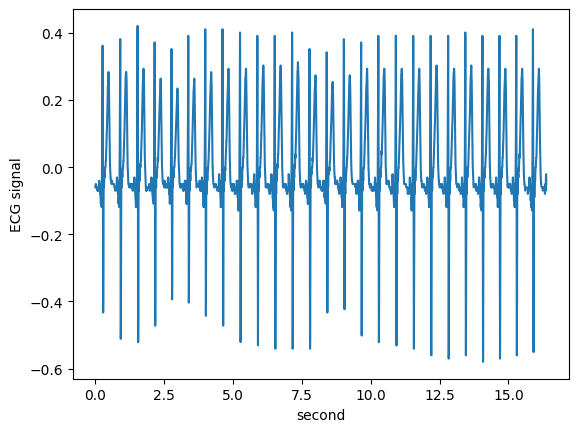

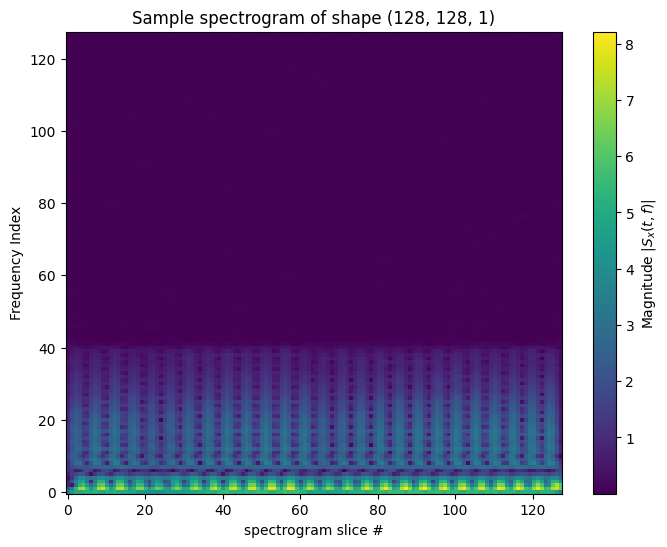

In [130]:
from pretraining import datasets
from transplant.datasets.icentia11k_spectrogram import spectrogram_preprocessor
# use raw data we grabbed earlier

# First let's plot the raw signal for comparison
print(f"Beat label: {datasets.icentia11k.ds_beat_names[data[1]]}")
_ = plt.plot(np.arange(len(data[0])) / 250, data[0])
_ = plt.xlabel("second")
_ = plt.ylabel("ECG signal")

# Now let's calculate and plot the spectrogram of this raw signal
x = spectrogram_preprocessor(
    np.squeeze(data[0]),
    window_size=256,
    stride=32,
    n_freqs=128,
    fs=250.0,
    ref=1,
)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
im1 = ax.imshow(x, cmap="viridis", aspect="auto")
fig.colorbar(im1, label="Magnitude $|S_x(t, f)|$")
ax.set_title(f"Sample spectrogram of shape {x.shape}")
ax.set_xlabel("spectrogram slice #")
ax.set_ylabel("Frequency Index")
ax.invert_yaxis()
plt.show()

### Ablation Model: 2-D ResNet-18v2
The model chosen for the ablation study using spectrograms is similar to the original model used, but is a 2-D ResNet-18v2. It is presented here:

[Link](https://github.com/songrise/CNN_Keras/blob/main/src/ResNet-18.py) to base code for the model that we used in this project, with the updated version in our repo [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/transplant/modules/resnet2d.py)

This ResNet architecture is based on the original design by He, et al <cite data-cite="he2016identity">[10]</cite>.

* Model architecture
  * 18 layers
  * Input layer consists of convolution layer with 64 filters, kernel size=7x7 and stride=2. The output of the convolution layer passes through batch norm, ReLu and max-pooling layer sequentially.
  * The middle 16 layers consists of 8 residual blocks. A residual block consists of the following two components and outputs the sum of the two components' outputs.
    1. Two convolution layers, each followed by batch norm and ReLu
    2. A shortcut that passes the input through a convolution layer followed by batch norm.
  * Output layer is a classifier consisting of a densely-connected layer followed by softmax or sigmoid function.
  * Configurations of the residual blocks
    * 1st and 2nd: 64 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 3rd and 4th: 128 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 5th and 6th: 256 filters, kernel size=3x3, strides=2 and 1, respectively.
    * 7th and 8th: 512 filters, kernel size=3x3, strides=2 and 1, respectively.

* Pre-training objectives
  * The same as the original author's 1-D pre-training objectives.

* Fine-tuning objectives
  * The same as the original author's 1-D pre-training objectives (F1 score)

Pre-trained model weights we trained with patients 0-2047 of the _Icentia11k_ dataset (~20%) can be found downloaded from Google Drive [here](https://drive.google.com/file/d/1-2rY0cxoLG1xK-L7RNKNwX0fDDtpT5oo/view?usp=sharing).


Pre-trained model weights we trained with patients 0-9680 of the _Icentia11k_ dataset (~88%) can be found downloaded from Google Drive [here](https://drive.google.com/file/d/13Lv9ZLW2s9-ABLBIMRiK6NULWoQJ6_7j/view?usp=drive_link).

This model is built and displayed below for reference:
  

In [131]:
from transplant.modules.resnet2d import ResNet18_2D
import transplant.datasets.icentia11k as icentia11k

num_classes = len(icentia11k.ds_beat_names)
model = ResNet18_2D(num_classes=num_classes)
model.build(input_shape=(None, 64, 64, 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
)
model.summary(expand_nested=True)

Model: "res_net18_2d_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          multiple                  3200      
                                                                 
 batch_normalization_24 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 resnet_block_8 (ResnetBloc  multiple                  74368     
 k)                                                              
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_21 (Conv2D)         multiple                  36928    |
|                                                   

## Ablation Training

### Hyperparameters
To simplify the training and make comparisons easier, the same hyperparameters for pre-training and fine-tuning were used during the ablation study. These common parameters included the batch size and learning rates, sample rates, and frame size. The only different hyperparameters were those chosen for the pre-processing step. These are already listed in the preprocessing section.

### Computational Requirements
The computational requirements of the ablation study were higher for two reasons:

* The addition of the spectrogram preprocessing.
* A significantly larger model (11.2 million versus 4.5 million parameters).

For this reason, the NVIDIA L4 GPU with 22.4 GB RAM was chosen for for both pre-training and fine-tuning.

#### Pre-training
Due to the increased computational requirements, the pre-training for the ablation took nearly twice per patient as using the 1-D ResNet-18v2. Trainining with 88% percent of the patients in the icentia11k framework took 24 hours, which exceeded the google collab process runtime limit and prevented us from using 100% of the data.

* Average runtime per 1,000 patients: 2 hours, 29 minutes
* Total number of trials: 1
* GPU hours used: 24hrs
    - Frame size 4096
    - 9068 patients x 4096 samples per data = **8 million samples** (about 88% of the _Icentia11k_ dataset)
* Number of training epochs: 1

#### Fine-tuning
For fine-tuning, all of the data was pre-processed just once to reduce repeated computations during fine-tune training. The notebook to generate this data can be found [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/jupyter_notebooks/finetuning_spectrogram_preprocess.ipynb).

This reduced the extra computational burden of the ablation framework.

* Average runtime for each epoch: 15 seconds
* Total number of trials: 50
    - 10 trials for each of the three scenarios: random, 1%, 10% and 20%, 88%
* GPU hours used: About 14.2 hours total.
    - Random: 2.8 hours
    - 1%: 2.7hrs
    - 10%: 3.1 hours
    - 20%: 2.9 hours
    - 88%: 2.7 hours
* Number of training epochs: Maximum 200 per trial, but in practice, saw early stopping by far fewer epochs
    - Training for a single trial would typically complete within 20 minutes

### Training Code - Command Line Interface
The spectrogram pre-processing and the 2-D ResNet-18v2 are integrated into the original authors' codebase in our fork of the repo. As such, the same commands that were presented earlier can be used, with small modifications.

#### Pre-training
The only modification is the `--arch` (architecture) argument, which should be set to `--arch "resnet18_2d"`.

#### Fine-tuning
For fine-tuning, the same `--arch` modification is needed. Otherwise, the only difference is pointing the trainer to the correct pre-processed spectrogram data files.

As an example, the pre-training command is executed below using the same sample data as was used for the corresponding command in the 1-D ResNet-18v2 section:

In [132]:
PRETRAIN2D_JOB_DIR = "/tmp/pretrain2d/"

In [133]:
%%time
!python -m pretraining.trainer \
--job-dir {PRETRAIN2D_JOB_DIR} \
--task "beat" \
--train {DEMO_DATA_DIR} \
--arch "resnet18_2d" \
--epochs 2 \
--patient-ids 0 \
--steps-per-epoch 8 \
--samples-per-patient 4096 \
--batch-size 256 \
--frame-size 1024 \
--unzipped True \
--seed 2024

2024-05-06 15:31:16.983791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:31:16.983841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:31:16.985181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 15:31:18.020545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating working directory in /tmp/pretrain2d
Setting random state 2024
Building train data generators
# Patient IDs:  1
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
2024-05-

## Ablation Results

The procedure for generating the 2-D results is exactly the same as that for the 1-D results, just only with a different network structure. Thus the code used to generate the 1-D figures and tables above can be reused here.

In [134]:
RESULT2D_DIR = "/tmp/results2d/"

In [135]:
%%time
%%capture
!mkdir -p {RESULT2D_DIR}
!gdown 1GwhDdlvUVmJfQfY3slyfiR-ytcuDRQ8X -O {RESULT2D_DIR} --folder

CPU times: user 86.7 ms, sys: 32.2 ms, total: 119 ms
Wall time: 11.6 s


### Figures and Tables

Similar to the above "Results" section, we implement the analysis code in a separate file and import the analysis functions into this notebook. The code can be found on Github [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/report/analysis2d.py).

The code is in the `analysis2d` module, which we import below.

In [136]:
from report import analysis2d

Table 3: Epochs required to complete fine-tuning - comparison

Same setup as Table 1, but for the 2-D results.

In [137]:
history_all_2d = pd.read_csv(
    RESULT2D_DIR + "results2d_all/history_all.csv"
)
analysis2d.make_epoch_table(history_all_2d)

,Scenario,Mean,Std
0,Random,60.9,3.2
1,Pre-train 1,54.5,3.2
2,Pre-train 10,60.4,4.4
3,Pre-train 20,58.7,3.1
4,Pre-train 88,56.2,1.7


#### Figure 4: Average Validation Macro F1 by epoch across all fine-tunings

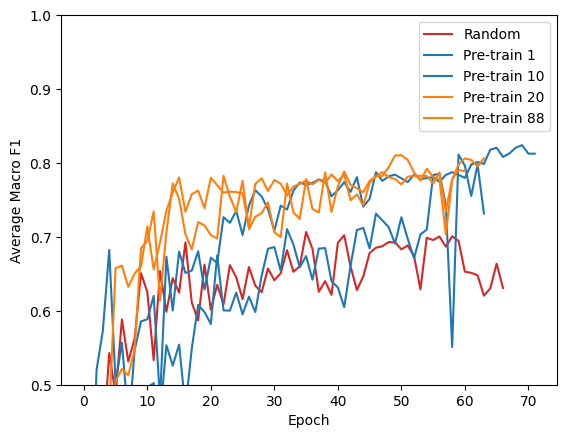

In [138]:
analysis2d.plot_f1_by_epoch(history_all_2d)

#### Figure 5: Average Validation Macro F1 by epoch with min/max shading - random initialization vs 88% pretraining

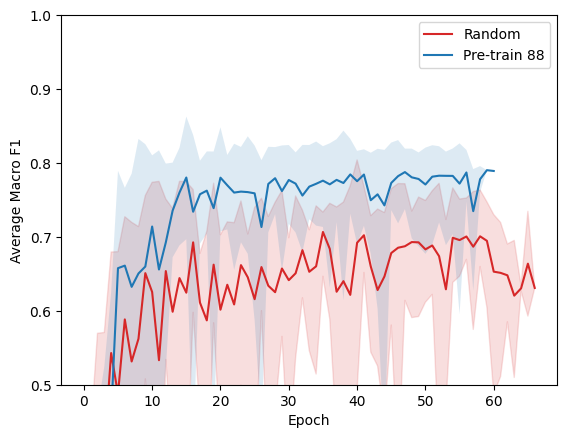

In [139]:
analysis2d.plot_f1_by_epoch_with_range(history_all_2d)

#### Table 4: Average Test Macro F1 Comparison

Same setup as Table 2, but for the 2-D results.

In [140]:
from transplant.utils import load_pkl

predictions_all_2d = load_pkl(
    RESULT2D_DIR + "/results2d_all/predictions_all.pkl"
)
analysis2d.make_f1_table(predictions_all_2d)

,Type,F1,F1n,F1a,F1o,F1p
0,Random,.715 (± .017),.887 (± .005),.681 (± .045),.694 (± .028),.600 (± .054)
1,Pre-train 1,.754 (± .013),.898 (± .007),.737 (± .022),.735 (± .016),.644 (± .044)
2,Pre-train 10,.762 (± .017),.898 (± .005),.751 (± .027),.736 (± .015),.662 (± .034)
3,Pre-train 20,.769 (± .014),.903 (± .005),.759 (± .015),.751 (± .011),.665 (± .041)
4,Pre-train 88,.765 (± .012),.900 (± .005),.774 (± .029),.752 (± .010),.632 (± .024)


#### Figure 5: Comparison 1-D versus 2-D Model Test Performance

We compare 1-D and 2-D model test macro F1 scores as a function of the percentage of data used to pre-train the models. Figure 4 will be covered in the "Discussion" section near the end of this report.

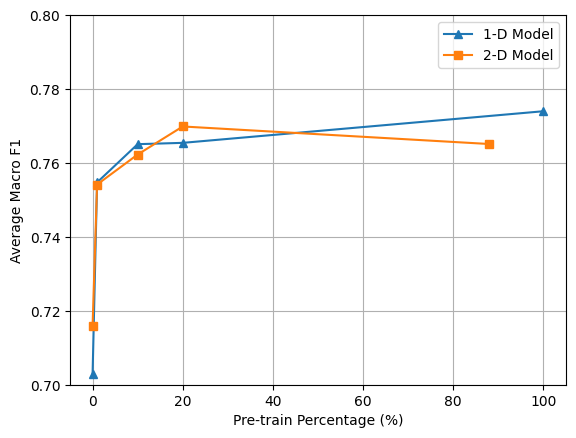

In [141]:
analysis2d.plot_f1_by_pretrain_percentage(predictions_all, predictions_all_2d)

## Ablation Discussion

Table 4 shows that pre-training with the 2-D ResNet-18v2, spectrogram-based model shows significant improvement to the fine-tuned model's F1 score. This shows that the framework in the original paper is robust to different input and model types.

However, Table 3 shows that pre-training the model did not reduce the number of epochs needed in the fine-tuning step. This differs from the 1-D results in the original paper.

Figure 5 visually shows how the fine-tuned model's macro F1 score changed as we used different percentages of the _Icentia11k_ dataset in the pre-training step. For both the 1-D results and 2-D results, most of the improvement is achieved using only 1% of the _Icentia11k_ dataset. For both models, macro F1 scores appear mostly flat after 10% or 20% of the pre-training data, with only minor changes to the F1 scores out to 100/88% of the pre-training data, respectively.


In general, performance is generally comparable for the two models, which shows that the pre-training principle is broadly applicable. However, the lack of performance improvement does not justify the increased computational cost and model size of the spectrogram / 2-D ResNet-18v2 approach.


## Ablation Future Work

Due to time limitations, there were many aspects of the spectrogram pre-processing that could be explored further.

* There were many spectrogram hyperparameters that were not adequately explored. It is possible that significantly better performance could be achieved with a higher or lower resolution spectrogram. The hyperparameters not explored were:
    * Stride
    * Window size
    * Window type
* It is noticeable that many higher frequency bins in the pre-training spectrogram contain low energy. This could be consistent across the board and introduce useless or noisy information.
* Downsampling the fine-tuning dataset from 360 Hz to 250 Hz to match the pre-training data may introduce aliasing that might affect the performance of the spectrogram model. These results are not present in the pre-training model and might affect the ability to transfer learned features.


# Discussion

## Implications of the Experimental Results

In general, we were able to reproduce the results in the original paper. Pre-training the 1-D ResNet-18v2 showed significant improvement in model performance as shown by the average F1 scores in Table 2. The pre-training also increased the speed of fine-tuning by reducing the number of epochs to convergence as shown in Table 1.

We also replicated the increased performance from pre-training in our ablation study which used pre-processing to generate spectrogram inputs to a 2-D ResNet-18v2 model. This shows the extensibility of the approach taken in the original paper. This increased performance can be seen in Table 4 and Figure 5.

We were not able to replicate decreased training time by pre-training the 2-D ResNet-18v2, as evidenced by Table 3. This, however, is a less important result than increased test performance.

Figure 4 compares the performance results of the 1-D ResNet-18v2 (original paper), and 2-D ResNet (our ablation) . This shows that both models similarly benefit from pre-training. In both cases, the majority of the benefit from pre-training is realized from using just 1% of the pre-training data, with more modest improvements seen by using more data. However, if the goal is optimal performance, more training data does seem to produce better results.

In general, the comparable results of using the paper authors' 1-D ResNet-18v2 and our ablation study's 2-D ResNet-18v2 with spectrogram preprocessing does not justify the increased computational requirements and model size.

## What Was Easy

### Code Quality

We have been very fortunate that not only was the source code publicly available, it was also well written and organized. This allowed us to more effectively spend our limited time on the core pieces of the code base, namely the pre-training and fine-tuning entrypoints, data pre-processing code, and model definitions.

We should say that the command line API was thoughtfully setup which made the execution of pre-training and fine-tuning trials relatively easy and gave us capacity to focus our attention to the results and learn more deeply about the deep learning mechanisms instead of getting bogged down in debugging work.

### Data Accessibility and Quantization

Both the pre-training and fine-tuning datasets were truly publicly available online. Also, the pre-training data came in quantized form. This played a subtly important role in that it allowed us to easily obtain subsets of the pre-train data despite the fact that the uncompressed version is too large to store with the resources at our disposal.

## What Was Difficult

Much of the time spent on this project may be considered standard work for deep learning projects, but each piece took significant amount of time, and had its own learning curve. In order to be able to reproduce the results and address Hypotheses 1 and 2, we had to work through:

- **Setting up development environment**: Google Colab + Google Drive + `git`.
- **Downloading large datasets**: The large pre-training dataset (> 200 GB) doesn't fit on our local hard drives, so this required interacting with _Academic Torrents_ and writing a script to download the data overnight directly to Google Drive.
- **Python dependencies**: Setting up a working environment, eliminating deprecated functions
- **Understanding the codebase**: Despite being relatively well documented, understanding the pieces of a foreign codebase takes time. For example, the pre-training code's definition of an epoch (a set number of samples) is different from the typical definition.
- **Understanding compute requirements**: Figuring out which GPUs make sense from a cost and time perspective. Planning and distributing all the training amongst the group.
- **Discrepancy between paper and code**: It is true that we should not blindly trust that the code is correct ("trust but verify"). But much close work was needed to reconcile what we were seeing in the code versus what the authors were reporting in the paper. Also, due to the lack of explanation for the code discrepancy, we spent much thought on whether the deviations we observed in our experimental results could be attributable to the discrepancies in the code as opposed to some other confounding factors.

As an extension to the original paper's work, our ablation work of adding spectrogram pre-processing and integrating a new model (2-D ResNet-18v2) had its own set of unique challenges:

- **Understanding spectrograms**: The Fourier transform is a fundamental mathematical tool used in a wide range of applications. In order to use these expert features as an input for our model, we had to have a reasonable understanding of the meaning of these outputs and how they might affect the model. For example, only after it was too late did we realize that downsampling from 360 Hz to 250 Hz might introduce aliasing that would be be visible in the spectrogram. Controlling for this might have been beneficial.
- **Limited time to tweak hyperparameters**: Due to the time constraints, many educated guesses at hyperparameters like window size, stride, and normalization techniques were made.
- **Integrating 2-D ResNet-18v2**: This model was not previously supported by the codebase, so integrating it to function within the existing API required carefully separating the convolutional layer and classification layer to match the approach taken by the paper. Significant training time was duplicated by making small mistakes in how to transfer the model weights correctly.
- **Exceeding Google Colab Pro runtime limit**: The increased training time from preprocessing and increased model size meant our training time exceeded the 24 hours runtime limit Google Colab Pro imposes. This meant we were only able to train using 88% of the pre-training data for the ablation study.


## Recommendations For Reproducibility

It would be a very good idea for such paper code to provide a **completely** specified environment configuration. The [original](https://github.com/kweimann/ecg-transfer-learning/blob/master/requirements.txt) `requirements.txt` provided did not specify all packages used, the exact versions used, nor performed complete pinning of dependencies.

For example, the `samplerate` dependency in the original requirements was deprecated when we started the project. We had to remove it and [implement the code from scratch](https://github.com/myles-i/DLH_TransferLearning/commit/38190172af5092d1ac72e8b705b0bc58b169bd3b).

Second, it would be good for the authors to ensure that their public code contents match what they report in their paper. Or if it is not possible, clearly document the discrepancy for the benefit of reproduction work. Here are some notable examples:

- The paper claims to pre-process the fine-tuning dataset to produce 60 second samples. However we found that the code documentation recommended the user to generate ~65 second samples.
    - This discrepancy did not materially affect our experimental results. However, it should be understood that such a discrepancy may affect reproduction work of another project more severely.
- The paper claims to use training accuracy as the early stopping metric for fine-tuning training. Specifically, terminate fine-tuning early if the training accuracy does not improve over 50 epochs. But an inspection of the fine-tuning entrypoint code revealed that the code was using validation loss as the metric for early stopping.
    - This discrepancy did materially affect our work in that our fine-tuning trials took fewer epochs to converge than reported by the authors.

In sum, it is still a very good thing that the authors released their paper source code to the public because it enables reproduction work to be more efficient and enables independent verification of the correctness of the original work.

# Public GitHub Repo
The repo with our code is available on [Github](https://github.com/myles-i/DLH_TransferLearning/tree/master). Specifically, the reports are located [here](https://github.com/myles-i/DLH_TransferLearning/tree/master/report).

Github full url: https://github.com/myles-i/DLH_TransferLearning/tree/master


## READMEs
A top level README.md for our code and results can be found at the root of the directory [here](https://github.com/myles-i/DLH_TransferLearning/blob/master/README.md). In addition, we have README.md files in subdirectories including:

- The [report folder](https://github.com/myles-i/DLH_TransferLearning/blob/master/report/README.md) (our work)
- The [pre-training directory](https://github.com/myles-i/DLH_TransferLearning/blob/master/pretraining/README.md) (from paper's repo)
- The [fine-tuning directory ](https://github.com/myles-i/DLH_TransferLearning/blob/master/finetuning/README.md) (from paper's repo)

# Appendix

We include figures and tables from the original paper here for the reader's convenience.

## Table 1
<img src='https://raw.githubusercontent.com/myles-i/DLH_TransferLearning/master/report/images/paper_table_1.png' width=500px>



## Figure 3(a)

<img src='https://raw.githubusercontent.com/myles-i/DLH_TransferLearning/master/report/images/paper_fig_3a.png' width=500px>

# References

1. Weimann, K., Conrad, T.O.F. Transfer learning for ECG classification. Sci Rep 11, 5251 (2021). https://doi.org/10.1038/s41598-021-84374-8
2. Kachuee, M., Fazeli, S., & Sarrafzadeh, M. ECG heartbeat classification: a deep transferable representation. in _2018 IEEE International Conference on Healthcare Informatics (ICHI)._ https://doi.org/10.1109/ichi.2018.00092 (2018).
3. Rahhal, M. A. _et al._ Deep learning approach for active classification of electrocardiogram signals. _Inf. Sci._ **345**, 340–354. https://doi.org/10.1016/j.ins.2016.01.082 (2016).
4. Rajan, D., Beymer, D., & Narayan, G. Generalization Studies of Neural Network Models for Cardiac Disease Detection Using Limited Channel ECG (2019). arXiv:1901.03295
5. J. Huang, B. Chen, B. Yao and W. He, “`ECG Arrhythmia Classification Using STFT-Based Spectrogram and Convolutional
 Neural Network`,” in IEEE Access, vol. 7
6. Shawn Tan, Satya Ortiz-Gagné, Nicolas Beaudoin-Gagnon, Pierre Fecteau, Aaron Courville, Yoshua Bengio, and Joseph Paul Cohen. Icentia11k single lead continuous raw electrocardiogram dataset (version 1.0). https://doi.org/10.13026/kk0v-r952, April 2022.
7. Tan, S. _et al._ Icentia11K: An Unsupervised Representation Learning Dataset for Arrhythmia Subtype Discovery (2019). arXiv:arXiv:1910.09570
8. Goldberger, A.L. _et al._ PhysioBank, PhysioToolkit,and PhysioNet: components of a new research resource for complex physiologic signals. _Circulation_ **101**, e215–e220. https://doi.org/10.1161/01.CIR.101.23.e215 (2000).
9. Clifford, G.D. _et al._ AF Classification from a short single lead ECG recording: the PhysioNet/computing in cardiology challenge 2017. _Comput. Cardiol._ (2017).
10. He, K., Zhang, X., Ren, S., & Sun, J. Identity Mappings in Deep Residual Networks (2016). arXiv:1603.05027.